# Language Modelling Script

In [1]:
import pandas as pd
import numpy as np
import pickle, logging, spacy, sys, os, json, requests
import matplotlib.pyplot as plt

from helpers.classes import Collection
from tqdm import tqdm
from bs4 import BeautifulSoup
from datetime import datetime

In [2]:
from helpers.cloze_generation import generate_clozes_from_point, named_entity_answer_generator as ne_answer_generator, noun_phrase_answer_generator as np_answer_generator

from helpers.language_modelling import run_language_model, summarise_results

from helpers.configs import CLOZE_MASKS
df = pd.read_pickle('pickles/dataset_20210625_184837.pkl')
# clozes_df = pd.read_json('pickles/clozes_20210715_212425.json')

# df = pd.read_pickle('pickles/collection_20210624_194932.pkl')
# clozes_df = pd.read_json('pickles/clozes_20210824.json')
clozes_df = pd.read_json('pickles/clozes_with_false_20210825.json') #contains negs

clozes_df['answer_type_agg'] = clozes_df['answer_type'].apply(
    lambda x: CLOZE_MASKS.get(x))

usabilities = pd.read_json('secondary/dataframe_usability_3.json')

In [14]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('fivethirtyeight')

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

# Data (Bulletin Main-Points) Preview

In [6]:
for points in df.point[:5]:
    print(points + '\n')

In 2019, approximate gross value added at basic prices (aGVA) of the UK non-financial business economy was estimated to be £1,313.9 billion; an increase of £42.8 billion (3.4%) compared with 2018.

The non-financial services sector, which accounted for over half (56.7%) of total aGVA in 2019, increased by £25 billion (3.5%) to £744.4 billion; transport and storage saw the highest increase in aGVA growth at £7.2 billion (8.6%) increasing from £84.4 billion to £91.6 billion.

Total turnover and purchases of the UK non-financial business economy were estimated to be £4,101.5 billion and £2,761.4 billion respectively; an increase of £70.5 billion (1.7%) and £25.8 billion (0.9%) compared with 2018.

Out of the 12 UK regions, 8 regions experienced growth in aGVA; the South East experienced the largest increase in aGVA of £17.3 billion to £214.4 billion, which was as increase of 8.8% in 2019.

West Midlands, Yorkshire and The Humber, Scotland and East Midlands, were the four regions decreasin

The non-financial services sector, which accounted for over half (56.7%) of total aGVA in 2019, increased by £25 billion (3.5%) to £744.4 billion; transport and storage saw the highest increase in aGVA growth at £7.2 billion (8.6%) increasing from £84.4 billion to £91.6 billion.


The non-financial services sector, which accounted for over half (56.7%) of total aGVA in 2019, increased by £25 billion (3.5%) to £74.4 billion; transport and storage saw the highest increase in aGVA growth at £7.2 billion (8.6%) increasing from £84.4 billion to £91.6 billion.

The non-financial services sector, which accounted for over half (56.7%) of total aGVA in 2019, increased by £25 billion (3.5%) to `<mask><mask><mask>`; transport and storage saw the highest increase in aGVA growth at 
£7.2 billion (8.6%) increasing from £84.4 billion to £91.6 billion.



a) Barack Obama and Trump both ran for president, and `mask` won.
b) Barack Obama and Trump both ran for president, and `mask``mask` won.
c) Barack Obama and Trump both ran for president, and `mask``mask``mask` won.

mean(a, b, c)

by averaging the probs of products of tokens we reduce the preference to shorter answers
(https://arxiv.org/pdf/2104.08315.pdf)


# Single Token Answers

In [3]:
RUN = False

## BERT Single Token Answers

In [21]:
from transformers import BertForMaskedLM, BertTokenizer, pipeline
from helpers.configs import CLOZE_MASKS
model = BertForMaskedLM.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

if RUN:
    results, entity_set, entities = run_language_model(df, model, tokenizer, 
        save_results= True, multi_token= False)
else:
    # load back if you didn't run them
    with open('results/bert_base_check_model_july2.json', 'r') as f:
        results = json.load(f)
    with open('results/bert_base_entity_set_july2.pickle', 'rb') as f:
        entity_set = pickle.load(f)
    with open('results/bert_base_entity_dictionary.json', 'r') as f:
        entities = json.load(f)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
print('BERT Single-Token Answers:\n')
count_correct, count_wrong, correct_preds, wrong_preds = summarise_results(results)

BERT Single-Token Answers:

Total Examples: 6184
Correct: 542, Incorrect: 5642
Percentage Correct: 8.765%


## ELECTRA Single Token Answers

In [4]:
from transformers import ElectraForMaskedLM, ElectraTokenizer
tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')
model = ElectraForMaskedLM.from_pretrained('google/electra-small-discriminator')

if RUN:
    results, entity_set, entities = run_language_model(df, model, tokenizer, 
        save_results= True, multi_token= False)
else:
    # load back if you didn't run them
    with open('results/electra_base_check_model_july2.json', 'r') as f:
        results = json.load(f)
    with open('results/electra_base_entity_set_july2.pickle', 'rb') as f:
        entity_set = pickle.load(f)
    with open('results/electra_base_entity_dictionary.json', 'r') as f:
        entities = json.load(f)

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForMaskedLM: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForMaskedLM were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['generator_predictions.LayerNorm.bias', 'generator_predictions.dens

In [6]:
print('ELECTRA Single-Token Answers:\n')
count_correct, count_wrong, correct_preds, wrong_preds = summarise_results(results)

ELECTRA Single-Token Answers:

Total Examples: 6184
Correct: 0, Incorrect: 6184
Percentage Correct: 0.0%


In [7]:
from transformers import ElectraForMaskedLM, ElectraTokenizer
tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator')
model = ElectraForMaskedLM.from_pretrained('google/electra-base-discriminator')

if RUN:
    results, entity_set, entities = run_language_model(df, model, tokenizer, 
        save_results= True, multi_token= False)
else:
    # load back if you didn't run them
    with open(
        'results/ElectraForMaskedLM_20210826_005034_results.json', 'r') as f:
        results = json.load(f)
    with open(
        'results/ElectraForMaskedLM_20210826_005034_entity_set.pickle', 'rb') as f:
        entity_set = pickle.load(f)
    with open(
        'results/ElectraForMaskedLM_20210826_005034_entity_dictionary.json', 'r') as f:
        entities = json.load(f)
    # with open('results/electra_base_check_model_july2.json', 'r') as f:
    #     results = json.load(f)
    # with open('results/electra_base_entity_set_july2.pickle', 'rb') as f:
    #     entity_set = pickle.load(f)
    # with open('results/electra_base_entity_dictionary.json', 'r') as f:
    #     entities = json.load(f)

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraForMaskedLM: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForMaskedLM were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['generator_predictions.LayerNorm.bias', 'generator_predictions.dense.

In [8]:
print('ELECTRA Single-Token Answers:\n')
count_correct, count_wrong, correct_preds, wrong_preds = summarise_results(results)

ELECTRA Single-Token Answers:

Total Examples: 6184
Correct: 0, Incorrect: 6184
Percentage Correct: 0.0%


## AlBERT Single Token Answers

In [9]:
from transformers import AlbertForMaskedLM, AlbertTokenizer
model = AlbertForMaskedLM.from_pretrained('albert-base-v2')
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

if RUN:
    results, entity_set, entities = run_language_model(df, model, tokenizer, 
        save_results= True, multi_token= False)
else:
    # load back if you didn't run them
    with open('results/albert_base_check_model_july2.json', 'r') as f:
        results = json.load(f)
    with open('results/albert_base_entity_set_july2.pickle', 'rb') as f:
        entity_set = pickle.load(f)
    with open('results/albert_base_entity_dictionary.json', 'r') as f:
        entities = json.load(f)

In [12]:
print('AlBERT Single-Token Answers:\n')
count_correct, count_wrong, correct_preds, wrong_preds = summarise_results(results)

AlBERT Single-Token Answers:

Total Examples: 6184
Correct: 500, Incorrect: 5684
Percentage Correct: 8.085%


## RoBERTa Single Token Answers

In [13]:
from transformers import RobertaTokenizer, RobertaForMaskedLM
model = RobertaForMaskedLM.from_pretrained('roberta-base')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

if RUN:
    results, entity_set, entities = run_language_model(df, model, tokenizer, 
        save_results= True, multi_token= False)
else:
    # load back if you didn't run them
    with open('results/roberta_base_check_model_july2.json', 'r') as f:
        results = json.load(f)
    with open('results/roberta_base_entity_set_july2.pickle', 'rb') as f:
        entity_set = pickle.load(f)
    with open('results/roberta_base_entity_dictionary.json', 'r') as f:
        entities = json.load(f)

In [14]:
print('RoBERTa Single-Token Answers:\n')
count_correct, count_wrong, correct_preds, wrong_preds = summarise_results(results)

RoBERTa Single-Token Answers:

Total Examples: 6184
Correct: 716, Incorrect: 5468
Percentage Correct: 11.578%


# Multi-Token Answers

In [13]:
# RAN ON GOOGLE COLAB
# via run_multitoken_languagemodel.py

In [15]:
from transformers import RobertaForMaskedLM, RobertaTokenizerFast
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

with open('results/RobertaForMaskedLM_20210714_192239_results.json', 'r') as f:
    results = json.load(f)
with open('results/RobertaForMaskedLM_20210714_192239_entity_set.pickle', 'rb') as f:
    entity_set = pickle.load(f)
with open('results/RobertaForMaskedLM_20210714_192239_entity_dictionary.json', 'r') as f:
    entities = json.load(f)

In [16]:
print('RoBERTa Multi-Token Answers:\n')
count_correct, count_wrong, correct_preds, wrong_preds = summarise_results(results)

RoBERTa Multi-Token Answers:

Total Examples: 6184
Correct: 654, Incorrect: 5530
Percentage Correct: 10.576%


# Why is Multi-Token RoBERTa worse than the Single-Token counterpart?

In [17]:
with open('results/roberta_base_check_model_july2.json', 'r') as f:
        single_results = json.load(f)
with open('results/RobertaForMaskedLM_20210714_192239_results.json', 'r') as f:
        multi_results = json.load(f)

In [18]:
agree, disagree = 0, 0
disagreements = []

single_correct, multi_correct = [], []

agree_correct, agree_incorrect = [], []

disagree_single_correct, disagree_multi_correct = [], []

for row in range(2015):
    single_row, multi_row = single_results[row], multi_results[row]
    if len(single_row) and len(multi_row):
        for single, multi in zip(single_row, multi_row):
            
            single_pred = single[0].lower()
            multi_pred = multi[0].lower()
            truth = single[2].lower()
            
            # make sure first char isn't a whitespace
            if single_pred[0] == ' ':
                single_pred = single_pred[1:]
            if multi_pred[0] == ' ':
                multi_pred = multi_pred[1:]

            # if single-token and multi-token identical
            if single_pred == multi_pred:
                agree += 1
                # if they match truth
                if single_pred == truth:
                    # print(single_pred, multi_pred)
                    # print(multi)
                    agree_correct.append((truth))
                # if they both are wrong
                else:
                    agree_incorrect.append((single_pred, multi_pred, truth))
            
            # if single-token and multi-token disagree
            else:
                disagree += 1
                disagreements.append((single_pred, multi_pred, truth))
                # if single-token is correct
                if single_pred == truth:
                    disagree_single_correct.append((single_pred, multi_pred, truth))
                # if multi-token is incorrect
                if multi_pred == truth:
                    disagree_multi_correct.append((single_pred, multi_pred, truth))

In [19]:
print(f'Out of {agree} times that single- and multi-token predictions agreed: \n Both were {len(agree_correct)} correct and {len(agree_incorrect)} incorrect\n')

print(f'Out of {disagree} times that single- and multi-token predictions disagreed: \n Single-token was {len(disagree_single_correct)} correct and Multi-token was {len(disagree_multi_correct)} correct')

Out of 1385 times that single- and multi-token predictions agreed: 
 Both were 541 correct and 844 incorrect

Out of 4799 times that single- and multi-token predictions disagreed: 
 Single-token was 175 correct and Multi-token was 113 correct


In [20]:
disagree_multi_correct[:5]

[('it', 'scotland', 'scotland'),
 ('california', 'london', 'london'),
 ('2015', 'last year', 'last year'),
 ('new', 'monthly', 'monthly'),
 ('scotland', 'london', 'london')]

How do we explain that:

"Wales" is tokenised as two tokens. Single-token prediction (i.e. we just pass a single `<mask>`) is better? 

# Looking into the predictions

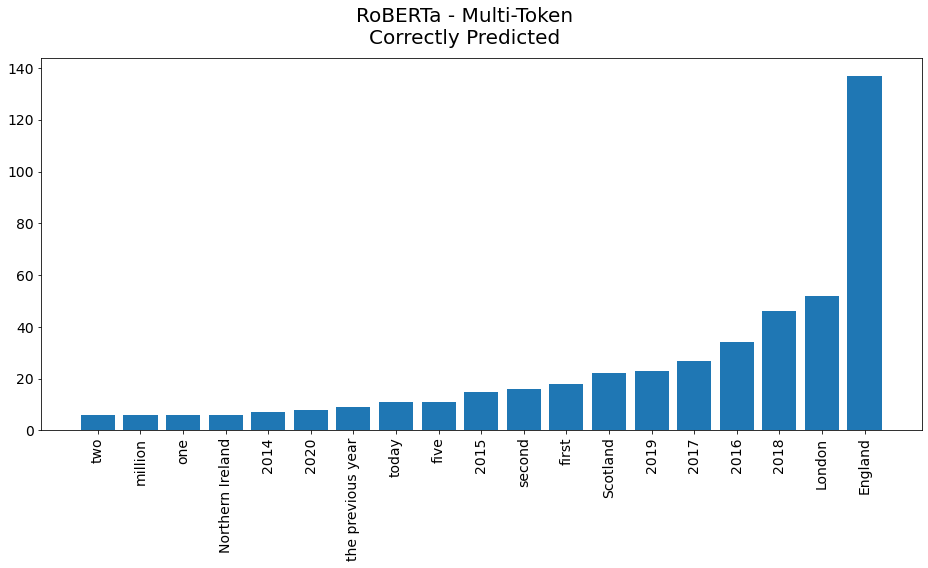

In [19]:
preds, counts = np.unique(correct_preds, return_counts = True)


_sorted = pd.DataFrame({'preds': preds, 'counts':counts}).sort_values('counts')

fig, ax = plt.subplots(1, 1, figsize= (13,8))
plt.bar(_sorted.preds[_sorted.counts > 5], _sorted.counts[_sorted.counts > 5])
# plt.bar(preds[counts > 5], counts[counts > 5])
ax.tick_params(axis='x', labelsize=14, rotation = 90)
ax.tick_params(axis='y', labelsize=14)
fig.suptitle('RoBERTa - Multi-Token\nCorrectly Predicted', fontsize = 20)
plt.tight_layout()
plt.show()

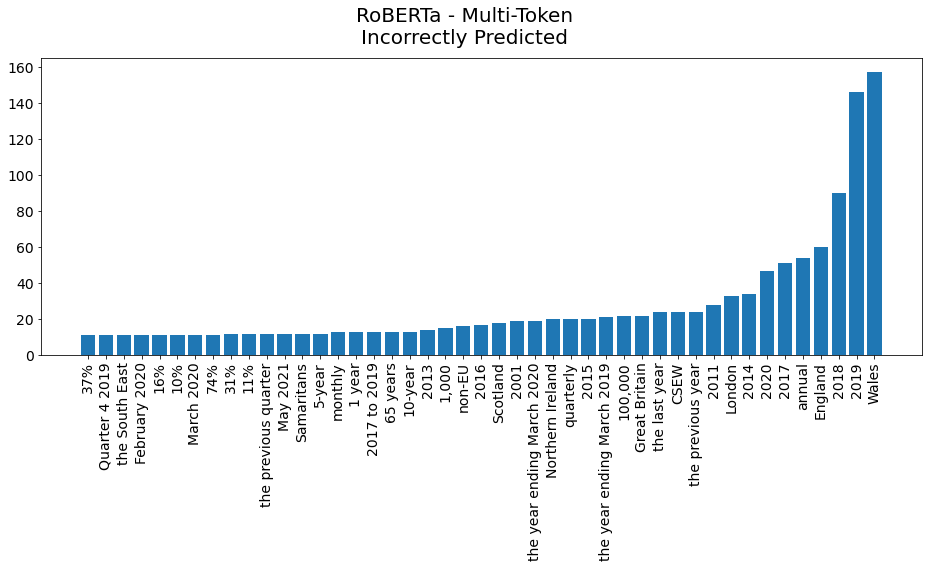

In [17]:
preds, counts = np.unique([x[1] for x in wrong_preds], return_counts = True)


_sorted = pd.DataFrame({'preds': preds, 'counts':counts}).sort_values('counts')

fig, ax = plt.subplots(1, 1, figsize= (13,8))
plt.bar(_sorted.preds[_sorted.counts > 10], _sorted.counts[_sorted.counts > 10])
ax.tick_params(axis='x', labelsize=14, rotation = 90)
ax.tick_params(axis='y', labelsize=14)
fig.suptitle('RoBERTa - Multi-Token\nIncorrectly Predicted', fontsize = 20)
plt.tight_layout()
plt.show()

- Ask Patrick (researchquestions) if he knows any ways to handle probabilities of different length tokens (preference of shorter tokens)

- Ask Patrick/Seb/ (RQ) is there a way to use t5 to answer cloze-style questions? papers links

- LREC maybe, submission of dataset, compare with PolitiHop, benchmark argument

# RoBERTa results picks best 0-5 length answer

THE REASON THERE IS SOME DISCREPANCY WITH THIS AND THE RESULTS BELOW IS HOW CONFIDENCE IS CALCULATED. HERE I DID SOME NORMALISATION THAT IS NOT COMMON.

In [3]:
with open('results/RobertaForMaskedLM_20210719_234849_results.json', 'r') as f:
    results = json.load(f)

In [4]:
print('RoBERTa best of 0-5 token-length answers:\n')
count_correct, count_wrong, correct_preds, wrong_preds = summarise_results(results)

RoBERTa best of 0-5 token-length answers:

Total Examples: 6184
Correct: 646, Incorrect: 5538
Percentage Correct: 10.446%


# RoBERTa picks best 0-5 length answer (perplexity and confidence)

In [5]:
with open('results/RobertaForMaskedLM_20210721_005608_results.json', 'r') as f:
    results = json.load(f)

In [6]:
count_correct, count_wrong, correct_preds, wrong_preds, conf_count_correct, conf_count_wrong, conf_correct_preds, conf_wrong_preds, perp_count_correct, perp_count_wrong, perp_correct_preds, perp_wrong_preds = \
    summarise_results(results, includes_perplexity=True)

Total Examples: 6184
Correct: 711, Incorrect: 5473
Percentage Correct: 11.497%
Confidence-based Answers: 11.497
Perplexity-based Answers: 0.0


In [5]:
df

,bulletin,type,point,data
0,businessindustryandtrade/business/businessserv...,date_and_percent,"In 2019, approximate gross value added at basi...",[/businessindustryandtrade/business/businessse...
1,businessindustryandtrade/business/businessserv...,date_and_percent,"The non-financial services sector, which accou...",[/businessindustryandtrade/business/businessse...
2,businessindustryandtrade/business/businessserv...,date_and_percent,Total turnover and purchases of the UK non-fin...,[/businessindustryandtrade/business/businessse...
3,businessindustryandtrade/business/businessserv...,date_and_percent,"Out of the 12 UK regions, 8 regions experience...",[/businessindustryandtrade/business/businessse...
4,businessindustryandtrade/business/businessserv...,date_and_percent,"West Midlands, Yorkshire and The Humber, Scotl...",[/businessindustryandtrade/business/businessse...
...,...,...,...,...
2010,peoplepopulationandcommunity/wellbeing/article...,date_and_percent,Trust in others in their neighbourhood was hig...,[/peoplepopulationandcommunity/wellbeing/datas...
2011,peoplepopulationandcommunity/wellbeing/article...,date_and_percent,Trust in others in their neighbourhood was hig...,[/peoplepopulationandcommunity/wellbeing/datas...
2012,peoplepopulationandcommunity/wellbeing/article...,date_and_percent,People in higher managerial occupations were m...,[/peoplepopulationandcommunity/wellbeing/datas...
2013,peoplepopulationandcommunity/wellbeing/article...,date_and_percent,Around 6 in 10 people (61%) reported feeling s...,[/peoplepopulationandcommunity/wellbeing/datas...


# T5 analysis

In [242]:
results = pd.read_json('results/t5_results_25august_clean.json')
results_large = pd.read_json('results/t5_large_29august_clean.json')

In [243]:
# results = pd.read_json('results/roberta_results_25august_clean.json')
# results_large = pd.read_json('results/roberta_large_29august_clean.json')


In [244]:
def _cleanup(x):
    if x[-1] in [',', '.']:
        x = x[:-1]

    return x

In [245]:
results['processed_pred'] = results.processed_pred.apply(lambda x:_cleanup(x))
results_large['processed_pred'] = results_large.processed_pred.apply(lambda x:_cleanup(x))

results['correct'] = (results['processed_pred']==results['processed_answer']).astype(int)
results_large['correct'] = (results_large['processed_pred']==results_large['processed_answer']).astype(int)

results['ans_length'] = results.processed_answer.apply(lambda x: len(x.split(' ')))
results_large['ans_length'] = results_large.processed_answer.apply(lambda x: len(x.split(' ')))


In [246]:
# results_large.groupby('ids').first().correct.sum() / results_large.groupby('ids').first().shape[0]
results.groupby('ids').first().correct.sum() / results.groupby('ids').first().shape[0]

0.10362438220757825

In [247]:
first_preds = results.groupby('ids').first()
first_preds_large = results_large.groupby('ids').first()

In [248]:
np.round(100 * first_preds.groupby('ans_length').correct.sum() / first_preds.groupby('ans_length').size(), 2)

ans_length
1    14.98
2     4.16
3     5.34
4     1.97
5     1.99
6     0.00
7     0.00
8     0.00
9     0.00
dtype: float64

In [249]:
np.round(100 * first_preds_large.groupby('ans_length').correct.sum() / first_preds_large.groupby('ans_length').size(), 2)

ans_length
1    18.72
2     7.57
3     8.78
4     2.96
5     4.48
6     0.74
7     0.00
8     0.00
9     0.00
dtype: float64

In [250]:
wrong_ans, wrong_counts = np.unique(results.loc[results.correct == 0].processed_answer.values, return_counts = True)
# most frequent wrong answers
wrong_count_sort = np.argsort(-wrong_counts)
# [print(wrong_ans[x], wrong_counts[x]) for x in wrong_count_sort]

correct_ans, correct_counts = np.unique(results.loc[results.correct == 1].processed_answer.values, return_counts = True)
# most frequent correct answers
correct_count_sort = np.argsort(-correct_counts)
# [print(correct_ans[x], correct_counts[x]) for x in correct_count_sort]

In [251]:
wrong_ans_large, wrong_counts_large = np.unique(results_large.loc[results_large.correct == 0].processed_answer.values, return_counts = True)

wrong_count_sort_large = np.argsort(-wrong_counts_large)


correct_ans_large, correct_counts_large = np.unique(results_large.loc[results_large.correct == 1].processed_answer.values, return_counts = True)

correct_count_sort_large = np.argsort(-correct_counts_large)

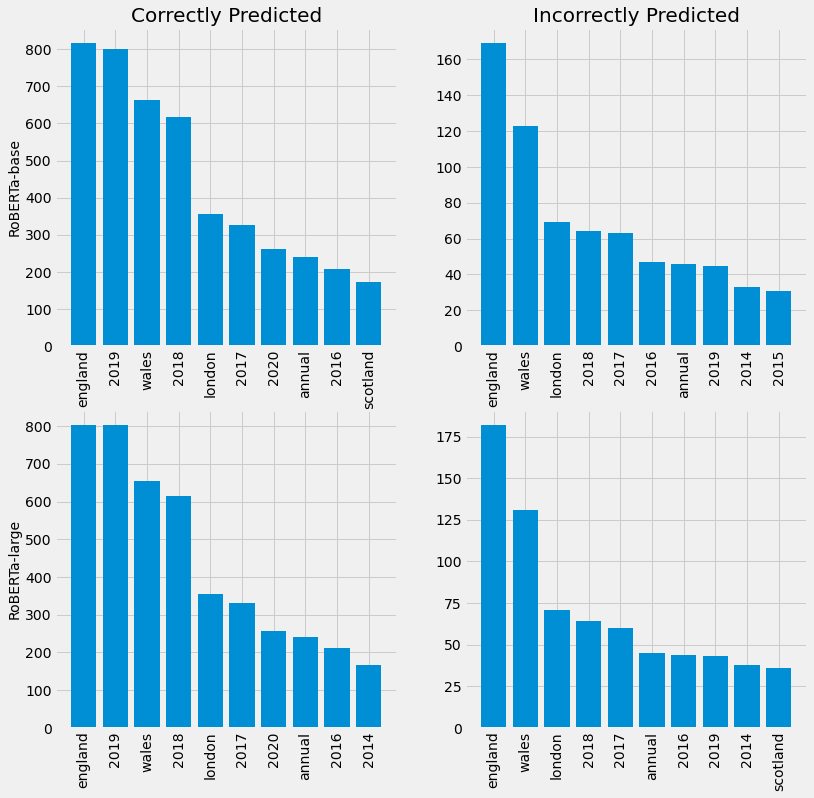

In [143]:
fig, ax = plt.subplots(2,2, figsize = (12,12))
ax[0,0].bar(wrong_ans[wrong_count_sort][:10], wrong_counts[wrong_count_sort][:10])
ax[0,1].bar(correct_ans[correct_count_sort][:10], correct_counts[correct_count_sort][:10])

ax[1,0].bar(
    wrong_ans_large[wrong_count_sort_large][:10], wrong_counts_large[wrong_count_sort_large][:10])
ax[1,1].bar(
    correct_ans_large[correct_count_sort_large][:10], correct_counts_large[correct_count_sort_large][:10])

ax[0,0].set_title('Correctly Predicted')
ax[0,1].set_title('Incorrectly Predicted')

ax[0,0].set_ylabel('T5-base', fontsize = 14)
ax[1,0].set_ylabel('T5-large', fontsize = 14)

ax[0,0].tick_params(axis='x', labelsize=14, rotation = 90)
ax[0,0].tick_params(axis='y', labelsize=14)
ax[0,1].tick_params(axis='x', labelsize=14, rotation = 90)
ax[0,1].tick_params(axis='y', labelsize=14)
ax[1,0].tick_params(axis='x', labelsize=14, rotation = 90)
ax[1,0].tick_params(axis='y', labelsize=14)
ax[1,1].tick_params(axis='x', labelsize=14, rotation = 90)
ax[1,1].tick_params(axis='y', labelsize=14)

plt.savefig(
    'overleaf_peripherals/t5_correct_incorrect.png', 
    facecolor = 'white', bbox_inches = 'tight')
plt.show()


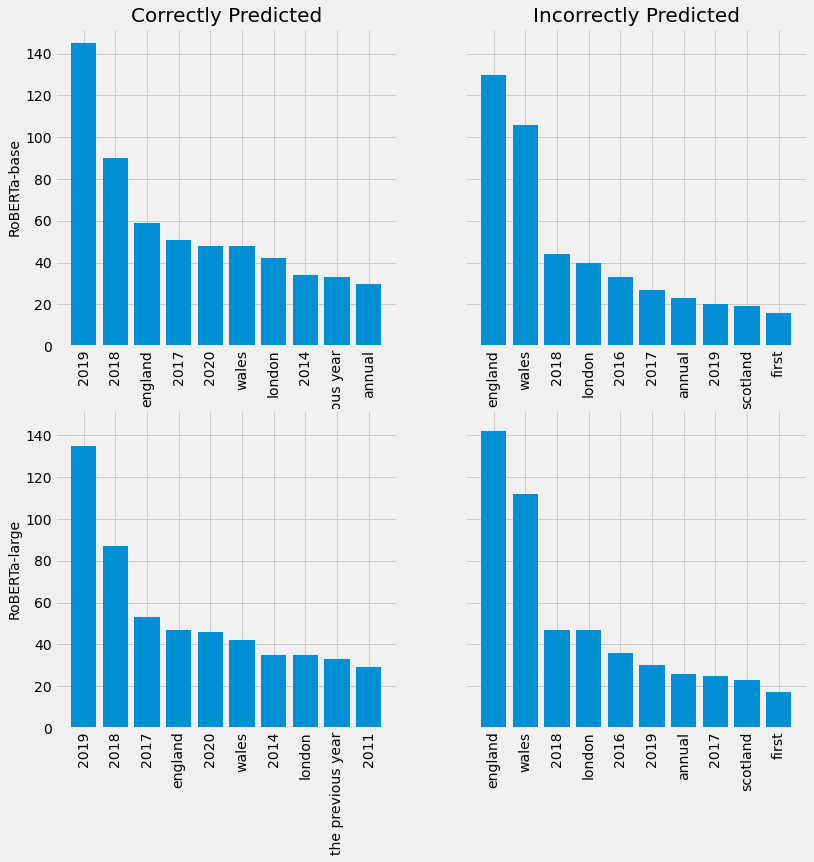

In [241]:
wrong_ans, wrong_counts = np.unique(first_preds.loc[first_preds.correct == 0].processed_answer.values, return_counts = True)
# most frequent wrong answers
wrong_count_sort = np.argsort(-wrong_counts)
# [print(wrong_ans[x], wrong_counts[x]) for x in wrong_count_sort]

correct_ans, correct_counts = np.unique(first_preds.loc[first_preds.correct == 1].processed_answer.values, return_counts = True)
# most frequent correct answers
correct_count_sort = np.argsort(-correct_counts)
# [print(correct_ans[x], correct_counts[x]) for x in correct_count_sort]

wrong_ans_large, wrong_counts_large = np.unique(first_preds_large.loc[first_preds_large.correct == 0].processed_answer.values, return_counts = True)

wrong_count_sort_large = np.argsort(-wrong_counts_large)


correct_ans_large, correct_counts_large = np.unique(first_preds_large.loc[first_preds_large.correct == 1].processed_answer.values, return_counts = True)

correct_count_sort_large = np.argsort(-correct_counts_large)

fig, ax = plt.subplots(2,2, figsize = (12,12), sharey = True)
ax[0,0].bar(wrong_ans[wrong_count_sort][:10], wrong_counts[wrong_count_sort][:10])
ax[0,1].bar(correct_ans[correct_count_sort][:10], correct_counts[correct_count_sort][:10])

ax[1,0].bar(
    wrong_ans_large[wrong_count_sort_large][:10], wrong_counts_large[wrong_count_sort_large][:10])
ax[1,1].bar(
    correct_ans_large[correct_count_sort_large][:10], correct_counts_large[correct_count_sort_large][:10])

ax[0,0].set_title('Correctly Predicted')
ax[0,1].set_title('Incorrectly Predicted')

ax[0,0].set_ylabel('RoBERTa-base', fontsize = 14)
ax[1,0].set_ylabel('RoBERTa-large', fontsize = 14)
# ax[0,0].set_ylabel('T5-base', fontsize = 14)
# ax[1,0].set_ylabel('T5-large', fontsize = 14)

ax[0,0].tick_params(axis='x', labelsize=14, rotation = 90)
ax[0,0].tick_params(axis='y', labelsize=14)
ax[0,1].tick_params(axis='x', labelsize=14, rotation = 90)
ax[0,1].tick_params(axis='y', labelsize=14)
ax[1,0].tick_params(axis='x', labelsize=14, rotation = 90)
ax[1,0].tick_params(axis='y', labelsize=14)
ax[1,1].tick_params(axis='x', labelsize=14, rotation = 90)
ax[1,1].tick_params(axis='y', labelsize=14)

# plt.savefig(
#     'overleaf_peripherals/t5_first_correct_incorrect.png', 
#     facecolor = 'white', bbox_inches = 'tight')
plt.savefig(
    'overleaf_peripherals/roberta_first_correct_incorrect.png', 
    facecolor = 'white', bbox_inches = 'tight')
plt.show()


In [194]:
ans, count = np.unique(results.loc[results.correct == 0].loc[results.processed_answer == 'england'].processed_pred.values, return_counts = True)

count_sort = np.argsort(-count)
[print(ans[x], count[x]) for x in count_sort]

scotland 140
britain 134
ireland 95
uk 88
london 74
europe 23
australia 22
india 16
wales 16
france 14
cardiff 12
canada 10
2017 8
english 8
china 7
2018 7
germany 7
africa 5
north 5
singapore 4
yorkshire 4
2016 4
2015 4
california 3
2019 3
manchester 3
society 3
nigeria 3
italy 2
general 2
january 2
japan 2
households 2
tanzania 2
adults 2
addition 2
contrast 2
the 2
children 2
2014 2
women 2
december 2
tenants 1
welsh 1
particular 1
westminster 1
ontario 1
october 1
november 1
northern 1
work 1
pakistan 1
patients 1
vancouver 1
us 1
region 1
turkey 1
town 1
total 1
regions 1
residents 1
russia 1
they 1
sheep 1
testing 1
spain 1
students 1
recession 1
ni 1
2009 1
nationally 1
debt 1
cornwall 1
communities 1
cattle 1
care 1
cancer 1
both 1
birmingham 1
bangladesh 1
asia 1
america 1
alberta 1
2013 1
2011 1
2010 1
delhi 1
denmark 1
employment 1
essex 1
national 1
mexico 1
men 1
may 1
kenya 1
kent 1
june 1
newcastle 1
worldwide 1
globally 1
florida 1
flation 1
february 1
fact 1
european 1

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [195]:
np.sum(['england' in x for x in results.loc[results.correct == 0].loc[results.processed_answer == 'england'].processed_pred.values]) / len(results.loc[results.correct == 0].loc[results.processed_answer == 'england'].processed_pred.values)

0.0

In [196]:
ans, count = np.unique(results_large.loc[results_large.correct == 0].loc[results_large.processed_answer == 'england'].processed_pred.values, return_counts = True)

count_sort = np.argsort(-count)
[print(ans[x], count[x]) for x in count_sort]

scotland 138
ireland 116
britain 113
uk 75
london 67
english 41
wales 24
australia 23
canada 16
india 14
2017 7
2015 7
europe 6
cornwall 6
ontario 5
china 5
2018 5
pakistan 4
iceland 4
france 4
society 4
denmark 4
kenya 4
yorkshire 4
california 4
2019 4
africa 4
sweden 3
germany 3
2016 3
manchester 3
alberta 2
2014 2
singapore 2
japan 2
general 2
america 2
greece 2
2012 2
victoria 2
contrast 2
nationally 2
pennsylvania 1
portugal 1
practice 1
ohio 1
practise 1
provinces 1
nsw 1
population 1
regions 1
british 1
november 1
2013 1
states 1
surrey 1
surveys 1
tenants 1
texas 1
the 1
toronto 1
total 1
vancouver 1
2011 1
welsh 1
women 1
rent 1
norway 1
national 1
ni 1
children 1
both 1
birmingham 1
counties 1
december 1
delhi 1
bangladesh 1
dublin 1
edinburgh 1
april 1
essex 1
estonia 1
finland 1
all 1
glasgow 1
great 1
households 1
nepal 1
nationwide 1
michigan 1
men 1
may 1
males 1
northern 1
addition 1
adults 1
january 1
italy 1
work 1
individuals 1
housing 1
life 1
2010 1


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [78]:
np.sum(['england' in x for x in results_large.loc[results.correct == 0].loc[results_large.processed_answer == 'england'].processed_pred.values]) / len(results_large.loc[results_large.correct == 0].loc[results_large.processed_answer == 'england'].processed_pred.values)

0.3522388059701492

In [35]:
ans, count = np.unique(results.loc[results.correct == 0].loc[results.processed_answer == '2018'].processed_pred.values, return_counts = True)

count_sort = np.argsort(-count)
[print(ans[x], count[x]) for x in count_sort]

2017 78
2015 61
2016 37
2018. 35
the same period last year 21
the uk 21
2012 14
the united states 13
2018, 11
2017, 11
2008 11
2014 11
the united kingdom 9
census 9
the previous year 8
none 8
2015. 7
2017. 7
the u.s. 6
2006 5
last year 5
the previous year. 4
the u.k. 4
the 1970s 4
england 4
the 1980s 4
in 2018 4
the same period last year. 3
dispersion 3
the second quarter 3
april 3
uk’s 3
england and wales 3
population 3
the summer 3
the 1990s 3
2016 and 2017 3
2014. 3
2016. 3
2010 3
the uk. 3
q1 2
the same subject 2
the same period. 2
2003. 2
terms of consumption 2
london 2
2005. 2
us census 2
the same year last year 2
labour force survey (lfs) 2
firm’s 2
the services industry 2
terms of disability pay gap 2
england and wales. 2
the country. 2
2016 . 2
the year before 2
china 2
the first quarter 2
the united states. 2
the eu 28 2
agva 2
uk's 2
2017 compared with 2017 2
2015 and 2016 2
the past. 1
the postneonatal period 1
the most recent peak in 2012 1
the most recent peak in 2014 1
t

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [256]:
first_preds_large.loc[first_preds_large.ans_length == 1].loc[first_preds_large.correct == 1]

,sequence,token_str,answer,processed_answer,processed_pred,correct,ans_length
ids,,,,,,,
00df3f37b236f03a66ee36b769680c33b7f87dc0,Data using this new methodology are published ...,first,first,first,first,1,1
015175c6949589bc5c5128e8a6261b03732df496,The total fertility rate (TFR) for England and...,2001,2001,2001,2001,1,1
0192b20dba0edd2eb470a22fae0a4c8937abc0a7,"In the financial year ending 2019 (FYE 2019), ...",first,first,first,first,1,1
01c5e701929d28a32e9c5aa106108cd882227b58,The total UK trade in services surplus (exclud...,2018,2018,2018,2018,1,1
01d69441d6eb3f620b342cae7c5fb657b0b94ba4,"By comparison, 49% of French-born emigrants li...",France,France,france,france,1,1
...,...,...,...,...,...,...,...
fe251d8f1dffef412548f17165d7ea15c64b9614,"Hartlepool, Glasgow City, South Tyneside and D...",2018,2018,2018,2018,1,1
fe59ab0c1c7e1d955e74cfe07c11f484144fbcaf,"In 2016, 41% of live births were first births,...",second,second,second,second,1,1
fecb00e1a33162e755c14be91d416f1983a1c7d2,"In 2016, 54% of all live births in England and...",2016,2016,2016,2016,1,1


In [258]:
ans, count = np.unique(first_preds_large.loc[first_preds_large.correct == 0].loc[first_preds_large.processed_answer == '2019'].processed_pred.values, return_counts = True)

count_sort = np.argsort(-count)
[print(ans[x], count[x]) for x in count_sort]

2017 31
2016 16
2018 7
2015 7
the uk 5
2010 5
2012 5
the study 3
2011 3
2017/18 3
 2
the year 2000 2
the united states 2
the survey 2
none 2
covid-19 2
2007 2
2005 2
2014 2
1975 1
the uk in 2019 1
the uk average 1
2001 1
uk’s 1
overall 1
the same-sex marriages 1
the same period 1
the previous year 1
the previous calendar year 1
the national average 1
spain  1
12-month 1
2016" 1
2009 to 2018 1
n.d 1
january to february 2017 1
india 1
homeless people 1
england and wales 1
england 1
value 1
all age groups 1
agva 1
a generation" 1
2020 1
2011/12 1
2012/13 1
2013 1
nature 1
wales 1


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]